# Homework №4
This homework will be dedicated to the Text-to-Speech(**TTS**), specifically the acoustic models.

In [1]:
from IPython import display
from dataclasses import dataclass

import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import torchaudio

import librosa
from matplotlib import pyplot as plt

/anaconda/envs/dl-ht2/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
set_seed(21)    

In [3]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [4]:
def viz(wav, sr, text):
    print(text)
    display.display(display.Audio(wav, rate=sr, normalize=False))

In [5]:
#win_len=1024, hop_len=256
def get_mel_lens(audio_lens):
    mel_lens = []
    for len_now in audio_lens:
        mel_lens.append(int((len_now - 1024)/256) + (1024//256)+1)
    return mel_lens

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

    In this homework we will use only LJSpeech https://keithito.com/LJ-Speech-Dataset/.
    Use text from `Normalized Transcription` field in transcripts.csv.
    
    Use the following `featurizer` (his configuration is +- standard for this task):

In [7]:
@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0
        
    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()
        
        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))
    

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """
        
        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [8]:
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)

In [10]:
wav, sr = torchaudio.load('../week01/audio.wav')
wav = wav.to(device)
mels = featurizer(wav).to(device)

OSError: ../week01/audio.wav not found or is a directory

In [ ]:
_, axes = plt.subplots(2, 1, figsize=(15, 7))
axes[0].plot(wav.squeeze())
axes[1].imshow(mels.squeeze())

plt.show()

### We will use pretrained Vocoder from Nvidia

In [51]:
!git clone https://github.com/NVIDIA/waveglow.git

Cloning into 'waveglow'...
remote: Enumerating objects: 190, done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (190/190), 435.59 KiB | 335.00 KiB/s, done.
Resolving deltas: 100% (106/106), done.


In [52]:
ls

README.md  dla-ht4-notebook.ipynb  waveglow/


    Download pretrained model from https://github.com/NVIDIA/waveglow

In [12]:
!pip install googledrivedownloader

In [13]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [17]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

In [23]:
gdd.download_file_from_google_drive(
    file_id='1A-APp73B0HkFGFcvUUCfswSBAJZSbf6F',
    dest_path='./new_dir'
)

### Use the following Vocoder for final quality validation

In [9]:
import sys
sys.path.append('waveglow/')

import warnings
warnings.filterwarnings('ignore')


class Vocoder(nn.Module):
    
    def __init__(self):
        super(Vocoder, self).__init__()
        
        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')['model']
        self.net = model.remove_weightnorm(model)
    
    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)
        
        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]
        
        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)
        
        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)
        
        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(spect.size(0), self.net.n_early_size, spect.size(2))
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)
        
        return audio

In [10]:
vocoder = Vocoder().to(device)
vocoder = vocoder.eval()

### Test pretrained vocoder

In [11]:
wav, sr = torchaudio.load('../week01/audio.wav')
wav = wav.to(device)
mels = featurizer(wav).to(device)

reconstructed_wav = vocoder.inference(mels)

OSError: ../week01/audio.wav not found or is a directory

In [17]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(wav.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

NameError: name 'reconstructed_wav' is not defined

In [18]:
display.Audio(reconstructed_wav.squeeze(), rate=22050)

NameError: name 'reconstructed_wav' is not defined

In [19]:
display.Audio(wav.squeeze(), rate=22050)

NameError: name 'wav' is not defined

# Model

    1) You need to implement Tacotron 2: https://www.dropbox.com/s/il9ai3ihh3nbcoo/Tacotron2.pdf?dl=0
    
    2) For fast convergence, implement Guided Attention: https://www.dropbox.com/s/tiibpqcdb1eieg4/GaidedAttention.pdf?dl=0
       It will increase convergence by several times!
    
    3) (Bonus) Implement Monotonic Attention: https://www.dropbox.com/s/6deupekgd4ep0kg/MonotonicAttention.pdf?dl=0
    
    4) (Bonus) Implement Tacotron with GST.
        For testing GST find 5-10 audio references with questioning tone and generate audio with this references.
        
    5) (PAY ATTENTION) Tacotron has RNNs, so don't forget about length masks.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!

    3) Good logging of experiments save your nerves and time, so we ask you to use W&B.
       Log loss, generated and real melspectrograms (in pair, i.e. real melspec and generated from correspond text). 
       Do not remove the logs until we have checked your work and given you a grade!

    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.

    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.

    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some melspec.

# Report

    Finally, you need to write a report in W&B https://www.wandb.com/reports. Add examples of generated mel and audio, compare with GT.
    Don't forget to add link to your report.

## DATA

In [12]:
ls

LJSpeech-1.1/  dla-ht4-notebook.ipynb  waveglow/
README.md      wandb/                  waveglow_256channels_universal_v5.pt


Use text from `Normalized Transcription` field in transcripts.csv.

In [12]:
import pandas as pd
from torch.utils.data import DataLoader

In [13]:
BATCH_SIZE = 16

In [14]:
class CharsInd:
    def __init__(self):
        self.char2ind = {}
        self.char2count = {}
        self.ind2char = {}
        self.n_chars = 1     # PAD
    
    def addSentence(self, sentence):
        for char in sentence:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2ind:
            self.char2ind[char] = self.n_chars
            self.char2count[char] = 1
            self.ind2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [15]:
class TextAudioDataset(torch.utils.data.Dataset):
    """Custom dataset containing text and audio."""

    def __init__(self, root='LJSpeech-1.1/', csv_path='metadata.csv', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root (string): Directory with all the data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.root = root
        self.csv = pd.read_csv(root+csv_path, sep='|', header=None)
        self.csv = self.csv.drop(columns=[1]).rename(columns={0:'filename', 2:'norm_text'})  # leave only normilized
        self.csv = self.csv.dropna().reset_index()
        self.transform = transform
        
        self.chars_indexed = CharsInd()
        for i in range(self.csv.shape[0]):
            self.chars_indexed.addSentence(self.csv.loc[i, 'norm_text'])

    def __len__(self):
        return self.csv.shape[0]
    

    def __getitem__(self, idx):
        utt_name = self.root + 'wavs/' + self.csv.loc[idx, 'filename'] + '.wav'
        utt = torchaudio.load(utt_name)[0].squeeze()
        norm_text = self.csv.loc[idx, 'norm_text']
        
        text_ohed = torch.Tensor(
                            [self.chars_indexed.char2ind[char_now] for char_now in norm_text]
                    ).type(torch.long)
        
        if self.transform:
            utt = self.transform(utt)

        sample = {'utt': utt, 'norm_text': norm_text, 'text_ohed':text_ohed}
        return sample

In [16]:
def my_collate_fn(data):
    wavs, wavs_lens = [], []
    texts = []
    texts_ohed, texts_ohed_lens = [], []    
        
    for el in data:
        wavs.append(el['utt'])
        wavs_lens.append(len(el['utt']))
        texts.append(el['norm_text'])
        texts_ohed.append(el['text_ohed'])
        texts_ohed_lens.append(len(el['text_ohed']))
    
    wavs_padded = torch.nn.utils.rnn.pad_sequence(wavs, batch_first=True)
    texts_ohed_padded = torch.nn.utils.rnn.pad_sequence(texts_ohed, batch_first=True, padding_value=75)
    
    return wavs_padded, wavs_lens, texts_ohed_padded, texts_ohed_lens, texts

### actual building

In [17]:
my_dataset = TextAudioDataset(csv_path='metadata.csv', transform=None)
my_dataset_size = len(my_dataset)
print('all train+val samples:', my_dataset_size)

all train+val samples: 13084


In [18]:
train_len = int(my_dataset_size * 0.85)
val_len = my_dataset_size - train_len
train_set, val_set = torch.utils.data.random_split(my_dataset, [train_len, val_len])

In [19]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          shuffle=False, collate_fn=my_collate_fn,
                          num_workers=0, pin_memory=False)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, 
                        shuffle=False, collate_fn=my_collate_fn, 
                        num_workers=0, pin_memory=False)

#### loaders check

In [20]:
'''for i, batch in enumerate(train_loader):
    utt, utt_lens, text_ohed, text_ohed_lens, text = batch
    
    print(utt.size(), utt_lens)
    print(text_ohed.size(), text_ohed_lens)
    
    viz(utts[0], 22050, text[0])
    if i == 2:
        break'''

'for i, batch in enumerate(train_loader):\n    utt, utt_lens, text_ohed, text_ohed_lens, text = batch\n    \n    print(utt.size(), utt_lens)\n    print(text_ohed.size(), text_ohed_lens)\n    \n    viz(utts[0], 22050, text[0])\n    if i == 2:\n        break'

#### Encoder check

In [21]:
'''enc = Encoder(input_size=my_dataset.chars_indexed.n_chars)
for i, batch in enumerate(train_loader):
        
    utt, utt_lens, text_ohed, text_ohed_lens, text = batch
    
    true_mel_lens = get_mel_lens(utts_lens)                   # из-за сдвига
    true_mel_lens = torch.Tensor(true_mel_lens).type(torch.long) - 1   ### ???
    max_true_mel_len = true_mel_lens.max()
        
        
    res, _ = enc(text_ohed, text_ohed_lens)
    print(res.size())
    
    viz(utt[0], 22050, text[0])
    if i == 2:
        break'''

'enc = Encoder(input_size=my_dataset.chars_indexed.n_chars)\nfor i, batch in enumerate(train_loader):\n        \n    utt, utt_lens, text_ohed, text_ohed_lens, text = batch\n    \n    true_mel_lens = get_mel_lens(utts_lens)                   # из-за сдвига\n    true_mel_lens = torch.Tensor(true_mel_lens).type(torch.long) - 1   ### ???\n    max_true_mel_len = true_mel_lens.max()\n        \n        \n    res, _ = enc(text_ohed, text_ohed_lens)\n    print(res.size())\n    \n    viz(utt[0], 22050, text[0])\n    if i == 2:\n        break'

## Architecture Tacotron2


In [22]:
class conv_bn_act(nn.Module):
    def __init__(self, in_channels=512, out_channels=512, kernel_s=5, act=nn.Identity(), d_rate=0.5):
        super(conv_bn_act, self).__init__()
        
        # batched 2d input, but first dim is considered channels, so kernel_size is actually (in_channels, kernel_s) 
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_s, padding=int((kernel_s - 1)/2))
        self.b_norm = nn.BatchNorm1d(out_channels)
        self.act = act
        self.dropout = nn.Dropout(d_rate)
        
        
    def forward(self, inputs):
        return self.dropout(self.act(
                    self.b_norm(self.conv(inputs))
               ))

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size=512, lstm_hidden_size=256):
        super(Encoder, self).__init__()
        
        self.embedder = nn.Embedding(input_size, emb_size, padding_idx=75)
        self.convs = nn.ModuleList([conv_bn_act(in_channels=emb_size, out_channels=emb_size, act=nn.ReLU())
                                    for i in range(3)])
        self.bi_lstm = nn.LSTM(input_size=emb_size,                  # ???
                               hidden_size=lstm_hidden_size,
                               batch_first=True,                     # ???
                               bidirectional=True)
        
    
    def forward(self, inputs, true_lens):
        # (BS, seq_len)
        x = self.embedder(inputs).transpose(1, 2)
        for conv in self.convs:
            x = conv(x)
        x = x.transpose(1, 2)
        # (BS, seq_len, emb_size)
        
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths=true_lens, batch_first=True, enforce_sorted=False)
        
        encoded, _ = self.bi_lstm(x)
        
        encoded_unpacked = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        return encoded_unpacked

### LS-attention COPIED

In [24]:
class LocationBlock(nn.Module):
    
    def __init__(
        self,
        attention_n_filters,
        attention_kernel_size,
        attention_dim
    ):
        super().__init__()
        
        padding = int((attention_kernel_size - 1) / 2)
        self.conv = nn.Conv1d(
            2, attention_n_filters, kernel_size=attention_kernel_size,
            padding=padding, bias=False
        )
        self.projection = nn.Linear(attention_n_filters, attention_dim, bias=False)
    
    def forward(self, attention_weights):
        output = self.conv(attention_weights).transpose(1, 2)
        output = self.projection(output)
        return output

In [25]:
class LocationSensitiveAttention(nn.Module):
    
    def __init__(
        self,
        lstm_hidden_size,
        attention_dim,
        attention_location_n_filters,
        attention_location_kernel_size
    ):
        super().__init__()
        
        self.query_layer = nn.Linear(lstm_hidden_size, attention_dim, bias=False)
        self.v = nn.Linear(attention_dim, 1, bias=False)
        self.location_layer = LocationBlock(
            attention_location_n_filters,
            attention_location_kernel_size,
            attention_dim
        )
        self.score_mask_value = -float("inf")
        
    def get_alignment_energies(
        self,
        fir_lstm_hidden,
        processed_memory,
        alphas_concat
    ):
        """
        fir_lstm_hidden: decoder output (batch, n_mel_channels * n_frames_per_step)
        processed_memory: processed encoder outputs (B, ???, attention_dim)
        alphas_concat: cumulative and prev. att weights (B, 2, max_time)
        """
        processed_query = self.query_layer(fir_lstm_hidden.unsqueeze(1))
        processed_alphas_concat = self.location_layer(alphas_concat)
        
        #print('LS-attention', processed_query.size(), processed_alphas_concat.size(), processed_memory.size())

        energies = self.v(torch.tanh(
            processed_query + processed_alphas_concat + processed_memory
        ))

        energies = energies.squeeze(2)
        return energies
    
    def forward(
        self,
        enc_outputs,
        processed_memory,
        fir_lstm_hidden,
        alphas_concat,
        mask=None
    ):
        """
        enc_outputs: encoder outputs
        processed_memory: processed encoder outputs
        fir_lstm_hidden: attention(first) rnn last output
        alphas_concat: previous and cummulative attention weights
        mask: binary mask for padded data
        """
        
        alignment = self.get_alignment_energies(
            fir_lstm_hidden, processed_memory, alphas_concat
        )

        alignment = alignment.masked_fill(mask, self.score_mask_value) if mask is not None else alignment

        attention_weights = F.softmax(alignment, dim=1)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), enc_outputs)
        attention_context = attention_context.squeeze(1)

        return attention_context, attention_weights

###  Decoder

In [26]:
from tqdm import tqdm

In [27]:
class prenet_layer(nn.Module):
    """1 layer of (Linear, Relu, Dropout). 2 of this for real prenet layer in Tacotron2"""
    
    def __init__(self, in_size=256, out_size=256, d_rate=0.5):
        super(prenet_layer, self).__init__()
        
        self.proj = nn.Linear(in_features=in_size, out_features=out_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(d_rate)
        
    def forward(self, inputs):
        return self.dropout(self.relu(self.proj(inputs)))

In [28]:
class Decoder(nn.Module):
    def __init__(self, prenet_size=256, att_size=512, lstm_hid_size=1024, after_lstm_d_rate=0.1):
        super(Decoder, self).__init__()
        
        self.prenet = nn.Sequential(prenet_layer(in_size=80, out_size=prenet_size), 
                                    prenet_layer(in_size=prenet_size, out_size=prenet_size))
        self.fir_LSTMCell = nn.LSTMCell(input_size=prenet_size+att_size, hidden_size=lstm_hid_size)
        self.fir_dropout  = nn.Dropout(after_lstm_d_rate)
        
        ### 128 is attention hidden kinda
        self.proj_memory  = nn.Linear(prenet_size*2, 128)
        self.LS_attention = LocationSensitiveAttention(lstm_hid_size, 128, 32, 31)
        
        self.sec_LSTMCell = nn.LSTMCell(input_size=lstm_hid_size+att_size, hidden_size=lstm_hid_size)
        self.sec_dropout  = nn.Dropout(after_lstm_d_rate)
        self.proj_mel     = nn.Linear(lstm_hid_size+att_size, 80)
        self.proj_exit    = nn.Linear(lstm_hid_size+att_size, 1)
        
        postnet_list = [conv_bn_act(in_channels=80, out_channels=512, act=nn.Tanh())]
        for i in range(5-2):
            postnet_list.append(
                conv_bn_act(in_channels=512, out_channels=512, act=nn.Tanh())
            )
        postnet_list.append(conv_bn_act(in_channels=512, out_channels=80, act=nn.Identity()))
        self.postnet = nn.Sequential(*postnet_list)   # * just unpacks list 
        
       
    
    def forward(self, enc_outputs, true_mels, true_lens, max_len, is_inference=False):
        BS = enc_outputs.size(0)
        seq_len = enc_outputs.size(1)
        processed_memory = self.proj_memory(enc_outputs)
        # create mask from true_lens for chars: True <=> PAD, not use
        true_lens = torch.Tensor(true_lens).type(torch.long)
        att_mask = torch.arange(max(true_lens)).repeat(BS, 1) >= true_lens.unsqueeze(1)
        att_mask = att_mask.to(enc_outputs.device)
        #print('att mask size', att_mask.size())
        #print('enc outputs in att size', enc_outputs.size())
        
        device = enc_outputs.device
        
        prenet_output = torch.zeros((BS, 256), device=device)         # всегда?
        att_context    = torch.zeros((BS, 512), device=device)
        fir_lstm_hidden = torch.zeros((BS, 1024), device=device)
        fir_lstm_context = torch.zeros((BS, 1024), device=device)
        alphas         = torch.zeros((BS, seq_len), device=device)
        alphas_sum     = torch.zeros((BS, seq_len), device=device)
        att_mat        = torch.zeros((BS, seq_len, 1), device=device)
        sec_lstm_hidden = torch.zeros((BS, 1024), device=device)
        sec_lstm_context = torch.zeros((BS, 1024), device=device)
        
        output_exits, output_mels = [], []
        for frame_num in range(max_len):
            
            ### concat + 1_lstm + 1_dropout
            fir_lstm_inputs = torch.cat((prenet_output, att_context), dim=1)  # в длинну 256+512
            fir_lstm_hidden, fir_lstm_context = self.fir_LSTMCell(fir_lstm_inputs, (fir_lstm_hidden, fir_lstm_context))
            fir_lstm_hidden = self.fir_dropout(fir_lstm_hidden)
            #print('1', fir_lstm_hidden.size(), fir_lstm_context.size())


            ### concat + LS_att
            alphas_concat = torch.stack((alphas, alphas_sum), dim=-1).transpose(1, 2)  # по новому дименшну
            
            att_context, alphas = self.LS_attention(enc_outputs, processed_memory, fir_lstm_hidden, alphas_concat,
                                                    mask=att_mask)
            alphas_sum = alphas_sum + alphas
            att_mat = torch.cat((att_mat, alphas.unsqueeze(2)), dim=2)              #### CHECK
            #print('2', att_context.size(), alphas_concat.size())


            ### concat + 2_lstm
            sec_lstm_inputs = torch.cat((fir_lstm_hidden, att_context), dim=1)  # в длину 1024+512
            sec_lstm_hidden, sec_lstm_context = self.sec_LSTMCell(sec_lstm_inputs, (sec_lstm_hidden, sec_lstm_context))
            sec_lstm_hidden = self.sec_dropout(sec_lstm_hidden)
            #print('3', sec_lstm_hidden.size(), sec_lstm_context.size())

            ### concat + FC x 2
            FC_inputs = torch.cat((sec_lstm_hidden, att_context), dim=1)   # в длину?
            output_mel = self.proj_mel(FC_inputs)
            output_mels.append(output_mel)
            output_exit = F.sigmoid(self.proj_exit(FC_inputs))
            output_exits.append(output_exit)
            #print('4', output_mel.size(), output_exit.size())
            
            ### Prenet
            if is_inference:
                prenet_output = self.prenet(output_mel)
                # output exit is (1,1) sized cause BS=1
                if output_exit.item() > 0.5:
                    break
            else:
                prenet_output = self.prenet(true_mels[:, :, frame_num])
            #print('5', prenet_output.size())
            
            
            
                    
        
        #### КОНЕЦ ЦИКЛА
        
        
        
        ### Postnet
        output_mels = torch.stack(output_mels, dim=-1) ### (BS, 80, num_frames)
        postnet_res = self.postnet(output_mels)   #(вроде сделано) эта свертка должна быть ПО ФРЕЙМАМ, каждый прогон цикла дает фрейм (1,80)  
        post_output_mel = postnet_res + output_mels
        
        
        
        # exits
        output_exits = torch.cat(output_exits, dim=1)
        
        return output_mels, output_exits, post_output_mel, att_mat

## FullModel

In [29]:
class Tacotron2(nn.Module):
    def __init__(self, input_size):
        super(Tacotron2, self).__init__()
        
        self.encoder = Encoder(input_size=input_size)
        self.decoder = Decoder()
        
    
    def forward(self, text_oheds, true_mels, text_lens, max_len):
        
        enc_outputs, _ = self.encoder(text_oheds, text_lens)

        output_mels, output_exits, post_output_mel, att_mat = self.decoder(enc_outputs, true_mels, text_lens, max_len)
        
        return output_mels, output_exits, post_output_mel, att_mat
    
    
    
    # call with true_mels=None and max_len=MAX_EVER_LEN is OK
    # BS=1
    def inference(self, text_oheds, true_mels, text_lens, max_len):
        
        enc_outputs, _ = self.encoder(text_oheds, text_lens)
        
        output_mels, _, _, att_mat = self.decoder(enc_outputs, true_mels, text_lens, max_len, is_inference=True)
        
        return output_mels, att_mat

In [30]:
def W_loss_mat(dims, g=0.2):
    BS, N, T = dims
    mat = torch.zeros((N, T))
    for n in range(N):
        for t in range(T):
            mat[N-n-1, t] = 1 - np.exp(- (n/N - t/T)**2 / (2*g**2))
    return mat.repeat(BS, 1, 1)

### RUNS

In [31]:
tacotron = Tacotron2(input_size=my_dataset.chars_indexed.n_chars).to(device)
count_parameters(tacotron)


28156929

In [32]:
opt = torch.optim.Adam(tacotron.parameters())

In [33]:
import wandb

wandb.init()
wandb.watch(tacotron)

wandb: Currently logged in as: kirili4ik (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
tacotron.train()

for ep_num in range(15):
    
    print('epoch num now will be', ep_num)
    
    for i, batch in tqdm(enumerate(train_loader)):

        opt.zero_grad()

        utt, utt_lens, text_ohed, text_ohed_lens, text = batch
        utt, text_ohed = utt.to(device), text_ohed.to(device)


        true_mel_lens = get_mel_lens(utt_lens)                    # из-за сдвига
        true_mel_lens = torch.Tensor(true_mel_lens).type(torch.long) - 1   ### ???
        max_true_mel_len = true_mel_lens.max()



        # ~ masking
        exit_mask = torch.arange(max_true_mel_len).repeat(utt.size(0), 1) >= true_mel_lens.unsqueeze(1)
        exit_mask = exit_mask.to(device)
        nullify_mask = ~exit_mask
        nullify_mask = nullify_mask.repeat(80, 1, 1).transpose(0, 1)

        true_mels = featurizer(utt)    
        true_mels = true_mels[:, :, :-1]  # сдвиг для inputs модели


        output_mels, output_exits, post_output_mel, att_mat = tacotron(text_ohed, true_mels, text_ohed_lens, max_true_mel_len)

        ### Losses
        # умножить на маску и вход и выход, чтобы нули где пады были
        output_mels = output_mels * nullify_mask
        true_mels = true_mels * nullify_mask
        L_pre  = F.mse_loss(output_mels, true_mels)             # true mel now




        # masking for CE
        # CE mask 1 less all than lens
        ce_mask = torch.arange(max_true_mel_len).repeat(utt.size(0), 1) >= (true_mel_lens).unsqueeze(1)
        ce_mask = ce_mask.to(device)
        zeros = torch.zeros((utt.size(0), max_true_mel_len)).to(device)
        exit_CE_ans = zeros.masked_fill(ce_mask, 1)

        L_exit = F.binary_cross_entropy(output_exits, exit_CE_ans)   ####### true is exit or not


        post_output_mel = post_output_mel * nullify_mask
        L_post = F.mse_loss(post_output_mel, true_mels)

        L_guided = (att_mat*W_loss_mat(att_mat.size()).to(device)).sum(dim=1).sum(dim=1).mean()

        loss = L_pre + L_exit + L_post + L_guided        

        wandb.log({'train_loss':loss,
                   'pre':L_pre.item(), 'exit':L_exit.item(), 'post':L_post.item(), 'guided':L_guided.item()})

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(tacotron.parameters(), 10)

        opt.step()
        
    torch.save({
        'model_state_dict': tacotron.state_dict(),
    }, 'taco'+str(ep_num))


0it [00:00, ?it/s]

epoch num now will be 0


696it [1:46:25,  9.17s/it]
0it [00:00, ?it/s]

epoch num now will be 1


696it [1:46:11,  9.16s/it]
0it [00:00, ?it/s]

epoch num now will be 2


696it [1:45:52,  9.13s/it]
0it [00:00, ?it/s]

epoch num now will be 3


696it [1:46:05,  9.15s/it]
0it [00:00, ?it/s]

epoch num now will be 4


67it [10:08,  8.87s/it]

torch.Size([3, 20, 141])


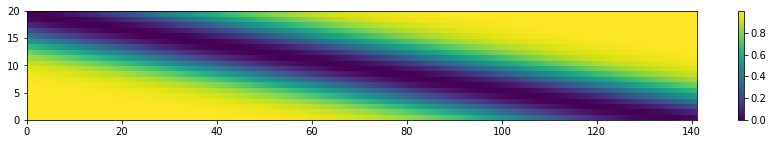

In [202]:
res = W_loss_mat(torch.rand((3, 20, 141)).size())

print(res.size())

plt.figure(figsize=(15,2))
plt.pcolormesh(res[2])
#plt.xlabel('Embedding Dimensions')
#plt.xlim((0, dimensions))
#plt.ylim((20, 0))
#plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [406]:
for i, batch in tqdm(enumerate(train_loader)):
    
    


    utt, utt_lens, text_ohed, text_ohed_lens, text = batch
    true_mel_lens = get_mel_lens(utts_lens)
    max_true_mel_len = max(true_mel_lens)
    true_mel_lens = torch.Tensor(true_mel_lens).type(torch.long)
    
    break

0it [00:00, ?it/s]


In [407]:
text_ohed = text_ohed.repeat(2, 1, 1)
text_ohed.size()

torch.Size([2, 3, 139])

In [408]:
text_ohed_lens

[139, 112, 116]

In [410]:
a = torch.nn.utils.rnn.pack_padded_sequence(text_ohed, lengths=text_ohed_lens, batch_first=True, enforce_sorted=False)
a

IndexError: index out of range in self

In [388]:
torch.nn.utils.rnn.pad_packed_sequence(a, batch_first=True, padding_value=75)

(tensor([[33, 12, 12,  8,  5,  9,  2, 10, 10,  8, 15, 10,  2, 10,  8,  5,  2,  3,
          10, 19,  8, 17,  5,  8,  5,  9, 10,  8, 29, 10,  4,  5,  2, 17, 12,  8,
          29,  2,  3, 21,  3,  4, 17, 12,  8, 29, 11, 28,  2,  5,  7,  8, 17,  4,
          19,  8, 14, 10,  4,  5, 10,  4, 16, 10, 19,  8,  5, 11,  8, 20, 11, 28,
           2,  5, 10, 10,  4,  8, 13, 10, 17,  2, 14, 54,  8,  5,  2, 17,  4, 14,
          18, 11,  2,  5, 17,  5,  3, 11,  4,  7,  8, 18, 17, 14, 14,  3,  4,  6,
           8, 14, 11, 21, 10,  8,  5,  3, 21, 10,  8,  3,  4,  8, 31, 10, 15,  6,
          17,  5, 10,  8, 10,  4,  8,  2, 11, 28,  5, 10, 26],
         [40,  9, 10, 14, 10,  8, 16, 11, 21, 18, 17,  2,  3, 14, 11,  4, 14,  8,
          15,  3, 12, 12,  7,  8,  9, 11, 15, 10, 25, 10,  2,  7,  8, 24, 10,  8,
           5,  2, 17,  4, 14, 12, 17,  5, 10, 19,  8,  3,  4,  5, 11,  8,  5, 10,
           2, 21, 14,  8, 17, 18, 18, 12,  3, 16, 17, 24, 12, 10,  8,  5, 11,  8,
          17,  4, 13,  8, 14, 18, 1

In [384]:
np.sum(text_ohed_lens)

367